### 第二部分：材料非线性 Euler-Bernoulli 梁（小变形）

#### 基本假设
- **小位移与小转角**：$ |w| \ll L $, $ |dw/dx| \ll 1 $
- **平截面假设** 仍成立
- **材料非线性**：应力-应变关系为非线性函数  
  $$
  \sigma = f(\varepsilon)
  $$
  例如：
  - **双线性弹塑性**：
    $$
    \sigma = 
    \begin{cases}
    E \varepsilon, & |\sigma| < \sigma_y \\
    \sigma_y + E_t (\varepsilon - \varepsilon_y), & \sigma \geq \sigma_y \\
    -\sigma_y + E_t (\varepsilon + \varepsilon_y), & \sigma \leq -\sigma_y
    \end{cases}
    $$
  - **Ramberg-Osgood**：
    $$
    \varepsilon = \frac{\sigma}{E} + 0.002 \left( \frac{\sigma}{\sigma_{0.2}} \right)^n
    $$

#### 应变-应力关系（截面层次）
梁截面上任意点的轴向应变为：
$$
\varepsilon_{xx}(x, y) = \frac{du}{dx} - y \frac{d^2 w}{dx^2}
$$
对应应力为：
$$
\sigma_{xx}(x, y) = f\big( \varepsilon_{xx}(x, y) \big)
$$

#### 内力计算（需数值积分）
- **轴力**：
  $$
  N(x) = \int_A \sigma_{xx}(x, y)  dA
  $$
- **弯矩**：
  $$
  M(x) = -\int_A y  \sigma_{xx}(x, y)  dA
  $$

👉 由于 $\sigma(\varepsilon)$ 非线性，**无法解析积分**，需在截面上进行 **Gauss 积分**。

---

#### 虚功原理（弱形式）
$$
\delta \Pi = \int_0^L \int_A \sigma_{xx}  \delta \varepsilon_{xx}  dA  dx - \delta W_{\text{ext}} = 0
$$
其中 $\delta \varepsilon_{xx} = \delta u' - y \delta w''$。

将位移场用形函数离散后，得到 **非线性代数方程组**：
$$
\mathbf{R}(\mathbf{U}) = \mathbf{F}^{\text{int}}(\mathbf{U}) - \mathbf{F}^{\text{ext}} = \mathbf{0}
$$

---

#### 求解策略：Newton-Raphson 迭代

在每一步迭代中：
1. 计算当前位移 $\mathbf{U}^{(k)}$ 下的 **内力向量** $\mathbf{F}^{\text{int}}$
2. 计算 **切线刚度矩阵** $\mathbf{K}^{\text{tan}}$
3. 求解修正方程：
   $$
   \mathbf{K}^{\text{tan}} \Delta \mathbf{U} = -\mathbf{R}^{(k)}
   $$
4. 更新位移：
   $$
   \mathbf{U}^{(k+1)} = \mathbf{U}^{(k)} + \Delta \mathbf{U}
   $$

##### 切线刚度矩阵组成
$$
\mathbf{K}^{\text{tan}} = \int_0^L \mathbf{B}^\top \mathbf{D}^{\text{tan}} \mathbf{B}  dx
$$
其中：
- $\mathbf{B}$：应变-位移矩阵（与线性情况相同）
- $\mathbf{D}^{\text{tan}} = \frac{d\sigma}{d\varepsilon}$：**材料切线模量**（在截面上非均匀！）

> ⚠️ 注意：由于 $\sigma(\varepsilon)$ 非线性，$\mathbf{D}^{\text{tan}}$ 依赖于当前应变状态，需在每个 Gauss 点计算。

---

#### 截面积分：Gauss-Legendre 积分

对矩形截面（宽 $b$，高 $h$），在 $y$ 方向取 $n_{\text{gp}}$ 个 Gauss 点：
- Gauss 点位置：$ y_i \in [-h/2, h/2] $
- 权重：$ w_i $
- 则：
  $$
  N \approx \sum_{i=1}^{n_{\text{gp}}} \sigma(\varepsilon(y_i))  b  w_i, \quad
  M \approx -\sum_{i=1}^{n_{\text{gp}}} y_i \sigma(\varepsilon(y_i))  b  w_i
  $$

通常 **3~5 个 Gauss 点** 足够捕捉弹塑性屈服。

---

Running default test for BilinearMaterial...


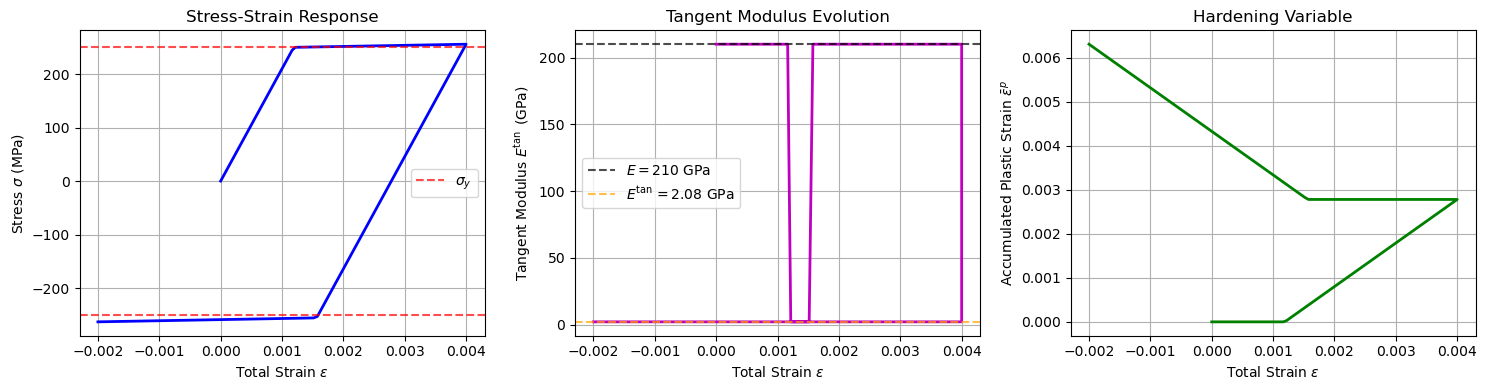

Yield strain ε_y = σ_y / E = 0.001190
Average plastic tangent modulus: 2.079 GPa
Theoretical E^tan = (E*H)/(E+H) = 2.079 GPa


In [1]:
%run src/material.py

In [1]:
# example_nonlinear.py
import sys, os
sys.path.insert(0, 'src')

In [2]:
# example_nonlinear.py
import numpy as np

# Import your classes
from material import BilinearMaterial
from material_nonlinear_beam import MaterialNonlinearBeamModel
from linear_beam import apply_boundary_conditions

# ==============================
# 1. Define mesh (nodes, elements)
# ==============================
L = 1.0
n_elements = 10
n_nodes = n_elements + 1
x_coords = np.linspace(0, L, n_nodes)
nodes = np.column_stack([x_coords, np.zeros(n_nodes)])  # shape: (n_nodes, 2)
elements = [[i, i+1] for i in range(n_elements)]        # list of [node_i, node_j]

# ==============================
# 2. Material and section
# ==============================
# ⚠️ 注意：这里要使用你 BilinearMaterial 实际的参数名！
# 你之前写的是 BilinearMaterial(E=..., sigma_y0=..., H=...)
# 但通常应该是 sigma_y 和 E_t（或 H）
mat_template = BilinearMaterial(E=210e9, sigma_y0=250e6, H=2e9)  # ← 修改为你的实际参数名

# ==============================
# 3. Create nonlinear model
# ==============================
model = MaterialNonlinearBeamModel(
    nodes=nodes, 
    elements=elements, 
    material_template=mat_template, 
    b=0.1, 
    h=0.1,
    ngp_section=3
)

# ==============================
# 4. Define loads and BCs
# ==============================
ndof = 3 * n_nodes
F_ext = np.zeros(ndof)
F_ext[-2] = -50e3  # Tip transverse load (50 kN downward)
fixed_dofs = [0, 1, 2]  # Clamped at left end

# ==============================
# 5. Newton-Raphson solver
# ==============================
U = np.zeros(ndof)
max_iter = 20
tol = 1e-6

for it in range(max_iter):
    F_int = model.compute_internal_force(U)
    R = F_ext - F_int
    
    # Apply BCs to residual
    for dof in fixed_dofs:
        R[dof] = 0.0
    
    res_norm = np.linalg.norm(R)
    print(f"Iter {it+1}: ||R|| = {res_norm:.3e}")
    if res_norm < tol:
        print("✅ Converged!")
        break
    
    K_tan = model.compute_tangent_stiffness(U)
    K_bc, R_bc = apply_boundary_conditions(K_tan, R, fixed_dofs)
    dU = np.linalg.solve(K_bc, R_bc)
    U += dU
else:
    raise RuntimeError("Newton-Raphson did not converge!")

print(f"Tip displacement: {U[-2]:.6e} m")

Iter 1: ||R|| = 5.000e+04
Iter 2: ||R|| = 4.749e-08
✅ Converged!
Tip displacement: -9.523810e-03 m



--- Load Step 1/100 ---
  Iter 1: ||R|| = 6.000e+02
  Iter 2: ||R|| = 7.050e-10

--- Load Step 2/100 ---
  Iter 1: ||R|| = 6.000e+02
  Iter 2: ||R|| = 1.052e-09

--- Load Step 3/100 ---
  Iter 1: ||R|| = 6.000e+02
  Iter 2: ||R|| = 2.253e-09

--- Load Step 4/100 ---
  Iter 1: ||R|| = 6.000e+02
  Iter 2: ||R|| = 2.787e-09

--- Load Step 5/100 ---
  Iter 1: ||R|| = 6.000e+02
  Iter 2: ||R|| = 1.529e-09

--- Load Step 6/100 ---
  Iter 1: ||R|| = 6.000e+02
  Iter 2: ||R|| = 2.890e-09

--- Load Step 7/100 ---
  Iter 1: ||R|| = 6.000e+02
  Iter 2: ||R|| = 5.771e-09

--- Load Step 8/100 ---
  Iter 1: ||R|| = 6.000e+02
  Iter 2: ||R|| = 4.194e-09

--- Load Step 9/100 ---
  Iter 1: ||R|| = 6.000e+02
  Iter 2: ||R|| = 4.636e-09

--- Load Step 10/100 ---
  Iter 1: ||R|| = 6.000e+02
  Iter 2: ||R|| = 2.909e-09

--- Load Step 11/100 ---
  Iter 1: ||R|| = 6.000e+02
  Iter 2: ||R|| = 3.957e-09

--- Load Step 12/100 ---
  Iter 1: ||R|| = 6.000e+02
  Iter 2: ||R|| = 6.838e-09

--- Load Step 13/100 ---

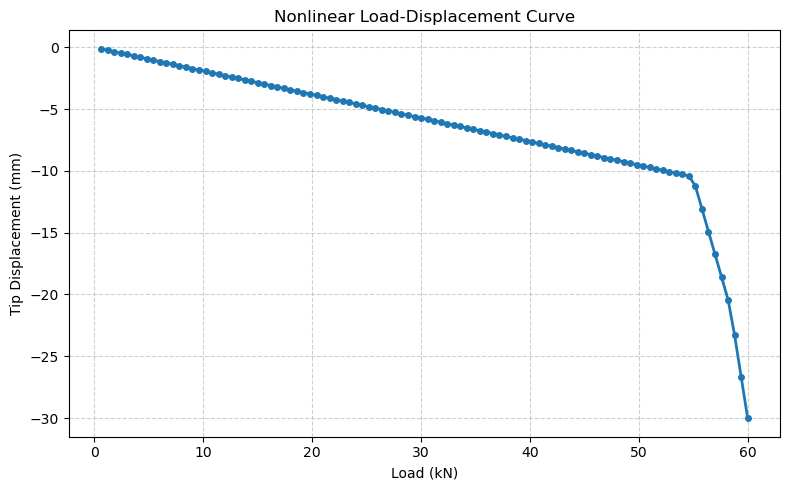


Final tip displacement: -3.001739e-02 m (-30.017 mm)


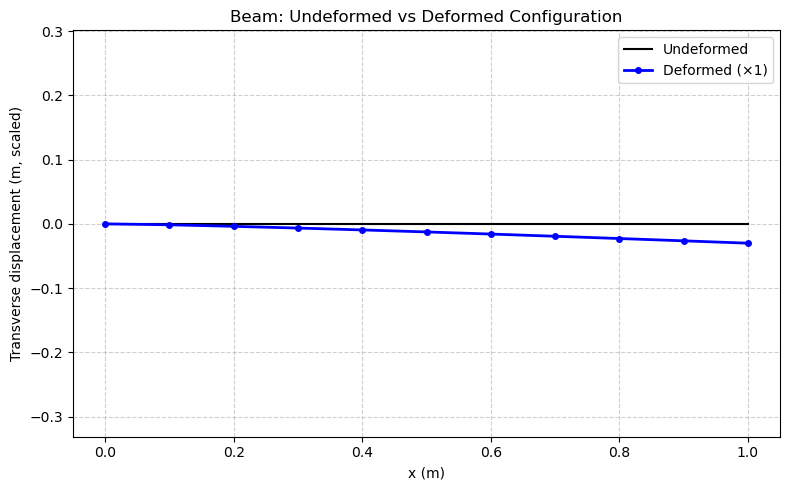

In [3]:
# example_nonlinear.py
import numpy as np
import matplotlib.pyplot as plt

# Import your classes
from material import BilinearMaterial
from material_nonlinear_beam import MaterialNonlinearBeamModel
from linear_beam import apply_boundary_conditions

# ==============================
# 1. Define mesh (nodes, elements)
# ==============================
L = 1.0
n_elements = 10
n_nodes = n_elements + 1
x_coords = np.linspace(0, L, n_nodes)
nodes = np.column_stack([x_coords, np.zeros(n_nodes)])  # shape: (n_nodes, 2)
elements = [[i, i+1] for i in range(n_elements)]        # list of [node_i, node_j]

# ==============================
# 2. Material and section
# ==============================
mat_template = BilinearMaterial(E=210e9, sigma_y0=250e6, H=2e9)

# ==============================
# 3. Create nonlinear model
# ==============================
model = MaterialNonlinearBeamModel(
    nodes=nodes, 
    elements=elements, 
    material_template=mat_template, 
    b=0.1, 
    h=0.1,
    ngp_section=3
)

# ==============================
# 4. Define loads and BCs
# ==============================
ndof = 3 * n_nodes
fixed_dofs = [0, 1, 2]  # Clamped at left end

# Total load
P_total = -60e3  # 50 kN downward
n_load_steps = 100    # 分 20 步加载

# To store results
load_history = []
tip_disp_history = []

# Start from zero displacement
U = np.zeros(ndof)

# ==============================
# 5. Incremental-Iterative Solver (Load steps + Newton-Raphson)
# ==============================
for step in range(1, n_load_steps + 1):
    print(f"\n--- Load Step {step}/{n_load_steps} ---")
    
    # Current target load
    P_current = (step / n_load_steps) * P_total
    F_ext = np.zeros(ndof)
    F_ext[-2] = P_current  # Apply at tip (transverse DOF)

    # Newton-Raphson iterations for this load step
    converged = False
    for it in range(20):  # max 20 iterations per step
        F_int = model.compute_internal_force(U)
        R = F_ext - F_int

        # Apply boundary conditions to residual
        for dof in fixed_dofs:
            R[dof] = 0.0

        res_norm = np.linalg.norm(R)
        print(f"  Iter {it+1}: ||R|| = {res_norm:.3e}")

        if res_norm < 1e-6:
            converged = True
            break

        # Compute tangent stiffness
        K_tan = model.compute_tangent_stiffness(U)
        K_bc, R_bc = apply_boundary_conditions(K_tan, R, fixed_dofs)
        dU = np.linalg.solve(K_bc, R_bc)
        U += dU

    if not converged:
        print("❌ Failed to converge at this load step!")
        break

    # Record result
    load_history.append(-P_current / 1e3)  # kN
    tip_disp_history.append(U[-2] * 1e3)   # mm

print("\n✅ Analysis completed.")

# ==============================
# 6. Visualization
# ==============================
plt.figure(figsize=(8, 5))
plt.plot(load_history, tip_disp_history, '-o', linewidth=2, markersize=4)
plt.xlabel('Load (kN)')
plt.ylabel('Tip Displacement (mm)')
plt.title('Nonlinear Load-Displacement Curve')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Optional: print final tip displacement
print(f"\nFinal tip displacement: {U[-2]:.6e} m ({U[-2]*1e3:.3f} mm)")

# ==============================
# 7. Plot Undeformed vs Deformed Shape
# ==============================
x_original = nodes[:, 0]  # Original x-coordinates
w_def = U[1::3]           # Transverse displacement: w = U[1], U[4], U[7], ...
# u_axial = U[0::3]       # Optional: axial displacement

# Scale deformation for visibility
scale = 1  # Magnify deformation by 100x (adjust as needed)

x_deformed = x_original  # Axial movement small; often ignored in plot
y_deformed = w_def * scale

plt.figure(figsize=(8, 5))

# Plot original (undeformed)
plt.plot(x_original, np.zeros_like(x_original), 'k-', linewidth=1.5, label='Undeformed')

# Plot deformed (magnified)
plt.plot(x_deformed, y_deformed, 'b-o', linewidth=2, markersize=4, label=f'Deformed (×{scale})')

plt.xlabel('x (m)')
plt.ylabel('Transverse displacement (m, scaled)')
plt.title('Beam: Undeformed vs Deformed Configuration')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.axis('equal')  # Optional: makes deflection look more realistic
plt.tight_layout()
plt.show()

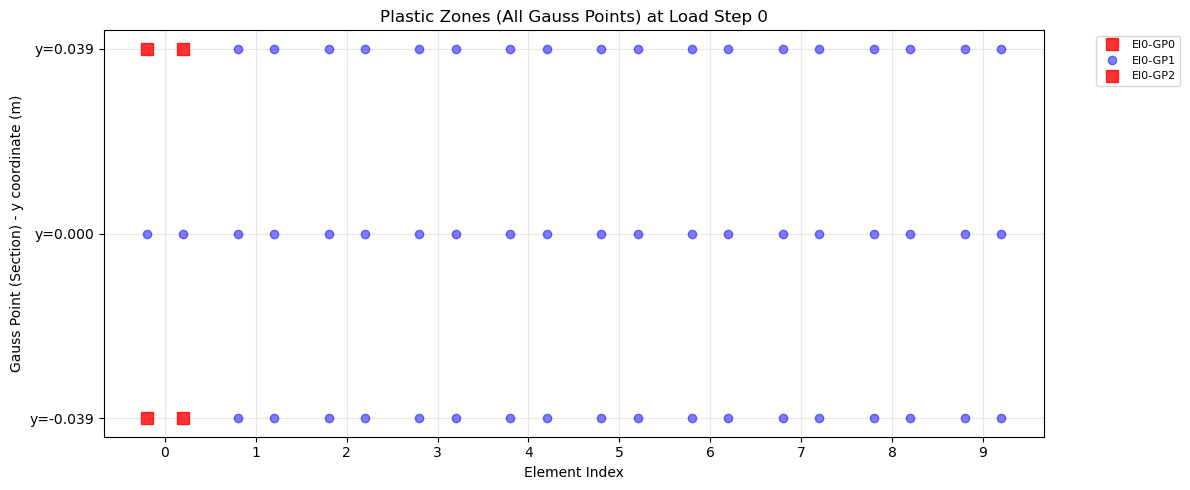

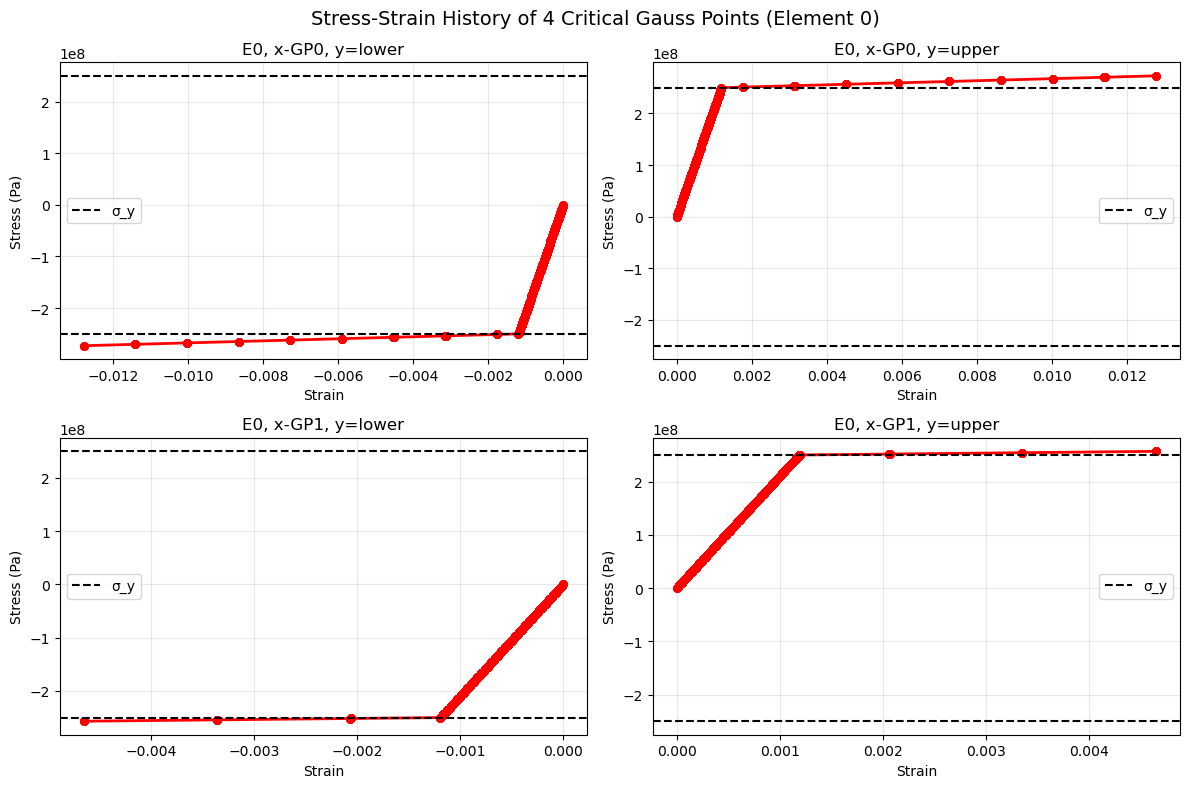

In [18]:
import matplotlib.pyplot as plt
import numpy as np

def plot_plastic_zones_complete(model, step=-1):
    """
    绘制所有高斯点的塑性状态（完整 10×2×3 = 60 个点）
    X轴：元素索引（0~9）
    Y轴：截面高斯点位置（y坐标）
    颜色：红色=塑性，蓝色=弹性
    """
    if not hasattr(model, 'gp_plastic_flag'):
        print("No plastic flag recorded.")
        return

    fig, ax = plt.subplots(figsize=(12, 5))
    ax.set_title(f"Plastic Zones (All Gauss Points) at Load Step {step+1}")
    ax.set_xlabel("Element Index")
    ax.set_ylabel("Gauss Point (Section) - y coordinate (m)")
    ax.grid(True, alpha=0.3)

    n_elem = len(model.elements)
    n_beam_gp = len(model.beam_gp)
    n_sec_gp = len(model.y_gp)

    for el_idx in range(n_elem):
        for i_gp in range(n_beam_gp):  # beam GP
            for j_gp in range(n_sec_gp):  # section GP
                y_coord = model.y_gp[j_gp]
                is_plastic = model.gp_plastic_flag[el_idx, i_gp, j_gp]
                
                # 用不同颜色区分截面位置
                marker = 's' if is_plastic else 'o'
                color = 'red' if is_plastic else 'blue'
                size = 8 if is_plastic else 6
                alpha = 0.8 if is_plastic else 0.5
                
                # 在 x = el_idx + i_gp*0.4 - 0.2 处画点（避免重叠）
                x_pos = el_idx + i_gp * 0.4 - 0.2  # 两个 beam GP 分开画
                ax.plot(x_pos, y_coord, marker, color=color, markersize=size, alpha=alpha,
                        label=f'El{el_idx}-GP{j_gp}' if el_idx == 0 and i_gp == 0 else "")

    # 设置刻度和标签
    ax.set_xticks(range(n_elem))
    ax.set_yticks(model.y_gp)
    ax.set_yticklabels([f"y={y:.3f}" for y in model.y_gp])
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    plt.tight_layout()
    plt.show()

def plot_selected_gp_history_separate(model):
    """
    Plot stress-strain history for 4 critical Gauss points in Element 0,
    each in a separate subplot.
    """
    if not hasattr(model, 'gp_stress_strain_history'):
        print("No stress-strain history recorded.")
        return

    # Initialize history lists
    histories = {
        'E0_BEAM0_Y0': {'strain': [], 'stress': []},  # lower surface, x-GP0
        'E0_BEAM0_Y2': {'strain': [], 'stress': []},  # upper surface, x-GP0
        'E0_BEAM1_Y0': {'strain': [], 'stress': []},  # lower surface, x-GP1
        'E0_BEAM1_Y2': {'strain': [], 'stress': []},  # upper surface, x-GP1
    }

    for step_data in model.gp_stress_strain_history:
        beam0_data = None
        beam1_data = None
        for item in step_data:
            if item['element'] == 0:
                if item['beam_gp'] == 0:
                    beam0_data = item['section_gauss_points']
                elif item['beam_gp'] == 1:
                    beam1_data = item['section_gauss_points']

        if beam0_data is None or beam1_data is None:
            continue

        histories['E0_BEAM0_Y0']['strain'].append(beam0_data[0][1])
        histories['E0_BEAM0_Y0']['stress'].append(beam0_data[0][2])

        histories['E0_BEAM0_Y2']['strain'].append(beam0_data[2][1])
        histories['E0_BEAM0_Y2']['stress'].append(beam0_data[2][2])

        histories['E0_BEAM1_Y0']['strain'].append(beam1_data[0][1])
        histories['E0_BEAM1_Y0']['stress'].append(beam1_data[0][2])

        histories['E0_BEAM1_Y2']['strain'].append(beam1_data[2][1])
        histories['E0_BEAM1_Y2']['stress'].append(beam1_data[2][2])

    # Create 2x2 subplots
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle('Stress-Strain History of 4 Critical Gauss Points (Element 0)', fontsize=14)

    colors = ['red', 'blue', 'green', 'orange']
    colors = ['red', 'red', 'red', 'red']
    titles = [
        'E0, x-GP0, y=lower',
        'E0, x-GP0, y=upper',
        'E0, x-GP1, y=lower',
        'E0, x-GP1, y=upper'
    ]

    sigma_y = model.material_template.sigma_y0

    for i, (key, data) in enumerate(histories.items()):
        ax = axes[i//2, i%2]
        if data['strain']:
            ax.plot(data['strain'], data['stress'], marker='o', 
                   color=colors[i], linewidth=2, markersize=5)
            ax.set_title(titles[i])
            ax.axhline(y=sigma_y, color='k', linestyle='--', label=f'σ_y')
            ax.axhline(y=-sigma_y, color='k', linestyle='--')
            ax.grid(True, alpha=0.3)
            ax.set_xlabel('Strain')
            ax.set_ylabel('Stress (Pa)')
            ax.legend()

    plt.tight_layout()
    plt.show()


plot_plastic_zones_complete(model, step=-1) 
plot_selected_gp_history_separate(model)